**Service Contract Valuation**

The goal of this project is to provide buyers of contract labor better information about the price of the service they are buying. To do this, I used a real world dataset. I used Asheville North Carolina's dataset which contains information about all public-private service contracts valued at over $5,000 created between years 2010 and 2022. In this project I am studying the change in price of the contracts. The price is the amount the buyer pays the contractor. The amount this price changes from the first price agreed upon and recorded in the system to the closing price that was actually paid is the price change.

There two reasons knowing how much a contract is likely to change in price is useful. First, we are providing buyers with more information on how much they are likely to actually spend, since that expected amount is often different from the original listed price, this improves budgeting and planning. The second reason is that buyers make their contracting purchase based on the price they expect to pay, and they often use the original price. Buyers want to know if that initial estimate is higher or lower than what they are likely to actually pay, this information that I am uncovering will lead buyers to make better purchasing decisions. I discuss these benefits and common reasons why prices change further in [this report](https://docs.google.com/presentation/d/1ibPUaiaAAmefSnHlG3ddaB2IQ4hUQrGM_PVEcZV3xkI/edit?usp=sharing).

In this notebook, I provide information to contract buyers by flagging which vendors in the dataset have a tendancy to charge either higher or lower closing prices compared to their original price. I use a statistical test to determine which vendors have such a strong price-change pattern that it unlikely to be a result of chance and is therefore likely to continue in the future.

**Result Summary**

Ultimately, I discovered 1 to 3 vendors (depending on the desired error tolerance, 5% and 15%) which all had overvalued initial prices, meaning they all had tendencies to revise prices downwards. These vendors were:

      Patton Construction Group
      Average price change: -6.85%
      Confidence Level: 95%

      Mc Gill Associates
      Average price change: -8.9%
      Confidence Level: 85%

      Environmental Testing Solution
      Average price change: -14.93%
      Confidence Level: 85%

I interpret these results as indicating two possibilities. (1) These vendors have a bias in their process for their original prices where they systematically overestimate their cost of the service. (2) These vendors are trying to charge more than they should for their contracts and are forced to lower the price enough times that it appears as a pattern.

Therefore I would reccomend that when buying from these three vendors that the expected cost of the service should be calculated by with this formula
$$
(1+~average~proportion~price~change~of~the~vendor)~~\times~~the~original~price
$$


---



I would also reccomend that the original estimated cost of the service is scrutinized to ensure that the vendor is not trying to overcharge

*the "proportion price change" is just $\frac{percent~change}{100}$*

**Load Dataset**

In [ ]:
#imports for data cleaning
import pandas as pd
import numpy as np
#imports for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#import asheville-nc contracts dataset from kaggle
import kagglehub
path = kagglehub.dataset_download("trobacker/asheville-nc-construction-and-repair-contracts")

Using Colab cache for faster access to the 'asheville-nc-construction-and-repair-contracts' dataset.


In [ ]:
data=pd.read_csv('/root/.cache/kagglehub/datasets/trobacker/asheville-nc-construction-and-repair-contracts/versions/1/Munis_Contracts_Asheville.csv')

**Data Cleaning**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4254 entries, 0 to 4253
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   OBJECTID              4254 non-null   int64  
 1   contract_number       4254 non-null   int64  
 2   contract_description  4254 non-null   object 
 3   contract_status       4254 non-null   object 
 4   contract_type         4254 non-null   object 
 5   contract_subtype      385 non-null    object 
 6   last_modified         4254 non-null   object 
 7   original_amount       4244 non-null   float64
 8   revised_amount        4244 non-null   float64
 9   vendor_id             4254 non-null   int64  
 10  vendor_name           4252 non-null   object 
 11  objectid_1            4254 non-null   int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 398.9+ KB


In [ ]:
#remove contract subtype since it only has 385 non-null values
data=data.drop('contract_subtype', axis=1)

In [ ]:
#we need to convert last_modified from string to datetime datatype
data['last_modified']=pd.to_datetime(data['last_modified'])

print(data['last_modified'].dtype) #check to see this worked

datetime64[ns, UTC]


In [ ]:
data.head()

,OBJECTID,contract_number,contract_description,contract_status,contract_type,last_modified,original_amount,revised_amount,vendor_id,vendor_name,objectid_1
0,1,91800268,CJIS/CDE - CONTINUATION OF SERVICES FOR FY 19 ...,CLOSED,GS (GEN SERV),2019-04-02 00:00:00+00:00,"1,037,830.00","877,933.38",416,BUNCOMBE COUNTY FINANCE DEPT,0
1,2,91500051,DISASTER AND ENS REGISTRATION SERVICES ...,CLOSED,GS (GEN SERV),2015-05-18 00:00:00+00:00,"6,000.00","6,000.00",2706,UNITED WAY OF ASHEVILLE & BUNC,1
2,3,91000424,WEED & SEED CONTRACTOR ...,CLOSED,GS (GEN SERV),2010-08-19 00:00:00+00:00,"4,000.00","4,000.00",9010,PISGAH VIEW COMMUNITY PEACE GARDEN,2
3,4,91000588,WEED & SEED RESOURCE PROVIDER ...,CLOSED,GS (GEN SERV),2010-08-19 00:00:00+00:00,"3,500.00","3,500.00",9012,GREEN OPPORTUNITIES INC,3
4,5,91100175,CARWASH FOR POLICE VEHICLE FY 2010-2011 ...,CLOSED,GENERAL,2013-06-10 00:00:00+00:00,"32,000.00","91,344.00",20456,"ZIPS CAR WASH, LLC",4


In [ ]:
#we should drop the two columns called "ojbect ID" since they're redundant indexes
data=data.drop(['objectid_1', 'OBJECTID'], axis=1)

In [ ]:
data.isna().sum() #check for null values in each column

,0
contract_number,0
contract_description,0
contract_status,0
contract_type,0
last_modified,0
original_amount,10
revised_amount,10
vendor_id,0
vendor_name,2


In [ ]:
# 10 nulls out of 4254 is very few, so simply drop them
data = data.dropna()
#check to see this worked
data.isna().sum()

,0
contract_number,0
contract_description,0
contract_status,0
contract_type,0
last_modified,0
original_amount,0
revised_amount,0
vendor_id,0
vendor_name,0


In [ ]:
#make sure we didn't delete too many rows
print('rows deleted: '+str(4254-data.shape[0]))

rows deleted: 11


**Exploratory Data Analysis**

In [ ]:
#count how many contracts are in the dataset
print('rows:  %s' % (data.shape[0]))

rows:  4243


In [ ]:
data['contract_type'].value_counts() #displays the number of each contract type in the dataset

,count
contract_type,
GS (GEN SERV),2502
CON (CONSTUCT/R),559
PRO (PRO SERVIC),521
GENERAL,269
HUD (GEN SERV-HUD),138
ENT (ENTERTAIN),67
RNT (EQUIP RENT),65
LS (LEASE SVCS),39
LW (DON'T USE),31


I want to know how contract values change, but the dataset only has the original and closing price. So, I will calculate two new measures of price change based on the original and final price of each contract.

In [ ]:
#calculate the raw amount each contract changed by
data['amount_changed'] = data['revised_amount'] - data['original_amount']

In [ ]:
#the % increase of each contract
data['%_changed'] = (data['amount_changed'] / data['original_amount'])*100

In [ ]:
#descriptive statistics for original amount, amount changed, and % changed

pd.options.display.float_format = '{:20,.2f}'.format #avoid outputting in scientific notation since it's harder to read
data[['original_amount', 'amount_changed', '%_changed']].describe()

,original_amount,amount_changed,%_changed
count,"4,243.00","4,243.00","4,239.00"
mean,"109,060.49","32,347.21",inf
std,"684,108.50","775,711.84",NaN
min,0.00,"-3,492,363.86",-100.00
25%,"5,500.00",0.00,0.00
50%,"15,000.00",0.00,0.00
75%,"45,000.00",0.00,0.00
max,"34,928,000.00","34,129,187.32",inf


In [ ]:
#the owner of the dataset stated that the contracts minimum original value was $5,000
#I suspect that the infinite values for '%_changed' seen in the table are due to divinding by zero
#therefore, let's get rid of the contracts with original amounts between 0 and $4,999

print((data['original_amount'] < 5000).sum()) #number of contracts to be dropped

910


In [ ]:
#21 is not many, so I dropped them
data = data[data['original_amount'] >= 5000]

In [ ]:
data[['original_amount', 'amount_changed', '%_changed']].describe() #descriptive statistics again

,original_amount,amount_changed,%_changed
count,"3,333.00","3,333.00","3,333.00"
mean,"138,302.19","39,642.73",44.15
std,"769,306.23","873,672.58",932.80
min,"5,000.00","-3,492,363.86",-100.00
25%,"10,500.00",-133.08,-0.32
50%,"23,700.00",0.00,0.00
75%,"60,054.15",0.00,0.00
max,"34,928,000.00","34,129,187.32","52,973.99"


The amounts changed are highly skewed. The table indicates that the middle 50% of all changes were equal to \$\0. This means the price of most contracts stayed the same as the original amount, but the average amount changed is +\$\31,000.

Also, our maximum values indicate outliers. An increase of \%800,000 is definetly too high. Let's use the (1.5 x interquartile range) rule to flag outliers

In [ ]:
#using the interquartile range just for contracts that did change since the iqr is zero-zero for all contracts as seen above

data['changed_value'] = (data['amount_changed'] != 0).astype(bool)
changed = data[data['changed_value']==True] #create dataframe of only contracts that changed

top_75th_percentile = changed['%_changed'].quantile(0.75)
bottom_25th_percentile = changed['%_changed'].quantile(0.25)

iqr = top_75th_percentile - bottom_25th_percentile

upper_bound = top_75th_percentile + (1.5 * iqr)
lower_bound = bottom_25th_percentile - (1.5 * iqr)

print('upper bound: ' + str(upper_bound))
print('lower bound: ' + str(lower_bound))

upper bound: 155.5080470416071
lower bound: -110.43203198513352


In [ ]:
#any contract with a % change greater or less than the lower or upper bound is considered an outlier
outlier_mask = (data['%_changed'] > upper_bound) | (data['%_changed'] < lower_bound)
print('number of outliers: ' +str(data[outlier_mask]['contract_number'].count()))

number of outliers: 202


In [ ]:
no_outlier = data[~outlier_mask]

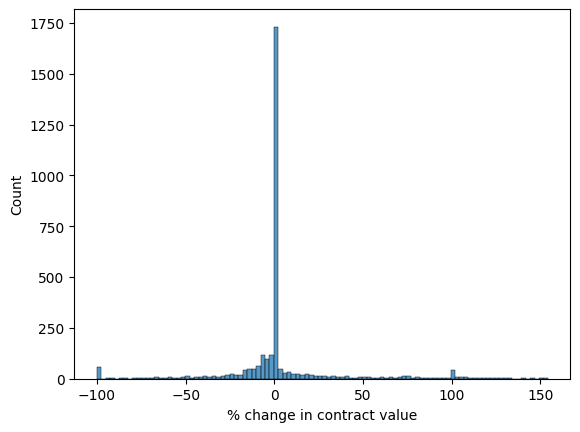

In [ ]:
#full distribution
sns.histplot(data=no_outlier, x='%_changed', binwidth=2.5)
plt.xlabel('% change in contract value')
plt.xticks()
plt.show()

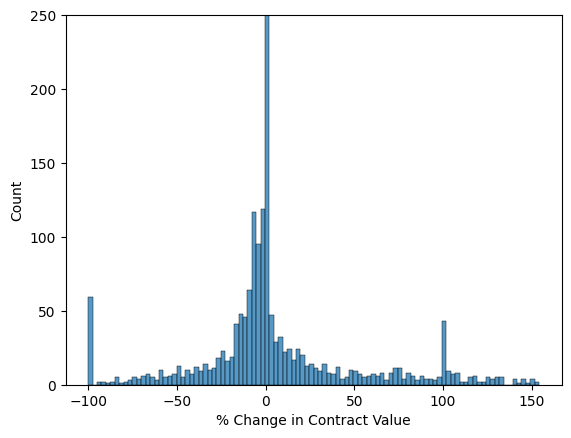

In [ ]:
#same graph but zoomed in to better see shape
sns.histplot(data=no_outlier, x='%_changed', binwidth=2.5)

plt.ylim(0,250) #limits y-axis to 250

plt.xlabel('% Change in Contract Value')
plt.xticks()
plt.show()

I noted that there are a large number of contracts that were cancelled, we know they were cancelled because they lost 100% of their original value.

We should exclude cancelled contracts because studying the probability a contract is cancelled is a very different question from what we're after which is the expected final price for services

In [ ]:
#to find out more about the expected price we'll pay for contracts, it may be best to exclude canceled ones
not_outlier_not_canceled = no_outlier[no_outlier['%_changed'] != -100]
#finally its also best to only look at contracts that are closed
#this is because those that are open still may revise upwards or downwards before they close
#leaving them in will bias the %_changed towards zero

closed = not_outlier_not_canceled[not_outlier_not_canceled['contract_status'] == 'CLOSED']

The distribution looks normal when zoomed in, but really it has this inflated number of zeroes.

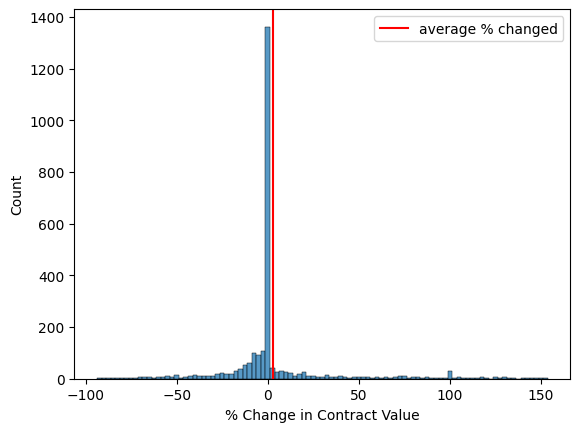

In [ ]:
#full distribution zoomed out
sns.histplot(data=closed, x='%_changed', binwidth=2.5)
plt.axvline(x=closed['%_changed'].mean(), color='r', label='average % changed')
plt.xticks()
plt.xlabel('% Change in Contract Value')
plt.legend()
plt.show()

In [ ]:
closed['changed_value'].value_counts(normalize=True) # proportion of contracts that changed value

,proportion
changed_value,
True,0.52
False,0.48


**Testing Vendors for Pricing Biases**

In order to determine which vendors are likely to increase or decrease from their original price when we buy from them, we will need to look at which vendors have multiple contracts which all either increased or decreased in price, and then, since many vendors do not sell a lot of contracts, use a statistical test to rule out the possibility that their pattern is due to random chance.



**Decision not to use the Conventional t-test**

I decided not to use on the usual difference of means t-test to test vendors because it will yeild both false positives and negatives. The difference of means t-test is great because the central limit theorem implies that it does not matter how the data is distributed the sample means will converge towards a normal distribution as long as the sample size is large. The issue with using a t-test here is that we have both non-normally distributed data \(right skew and spike at zero) **and** we also have very low sample sizes for some vendors who have sold 5 to 10 contracts.

**Robust Alternative Test**

Instead, I decided to test whether vendors had tendencies to revise prices upwards or downwards using the Mann-Whitney U test. The sizes of the price changes are skewed so that there are a few very large increases. To reduce the increased variance this will cause, the U-test essentially assigns an ordinal rank to each of the %changes in price in the entire dataset, then it tests the hypothesis for each vendor that their price changes tend to be of a higher or lower rank than the others. This test is a standard alternative to the t-test with for non-normal data and smaller samples. [More information about the test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test)

In [ ]:
from scipy.stats import mannwhitneyu #import Mann-Whitney U-test from scipy

'''
inputs: dataframe of whatever subset of the dataset is to be tested,
        minimum number of contracts a vendor must have sold in order to be tested (integer)

returns: dataframe of pvalues for hypotheses H0: distribution of vendor %price change == distribution of all %price change,
         Ha: distribution of vendor %price change != distribution of all %price change
'''

def rank_sum_test_ps(data, min_number_of_contracts):
  #empty lists to be put in output dataframe later
  pvals = []
  vendors = []
  vendor_names = []

#loop that applies the test to every vendor with at least the minimum number of sales
  for vendor in data['vendor_id'].unique(): #loop over every unique vendor
    if data[data['vendor_id']==vendor]['%_changed'].count() >= min_number_of_contracts: #only apply test to vendors who have sold the minimum # of contracts chosen
      vendor_array = data[data['vendor_id'] == vendor]['%_changed'] #array with all the price changes the test vendor has had
      control_array = data[data['vendor_id'] != vendor]['%_changed'] #array with all other price changes excluding the vendor being tested
      u, p = mannwhitneyu(control_array, vendor_array, alternative='two-sided') #run the rank-sum test

      #add the results to the lists
      pvals.append(p)
      vendors.append(vendor)
      vendor_names.append(data[data['vendor_id']==vendor]['vendor_name'])

      #if the vendor sold less contracts than the minimum, skip it and continue
    else:
      continue

      #output df that contains the vendors and their p-values from the test ordered from lowest to highest
  output_df = pd.DataFrame({'vendor_name':vendor_names, 'vendor_id':vendors, 'pvalue': pvals}).sort_values('pvalue', ascending=True)
  return output_df

In [ ]:
#run the function on the cleaned dataset with outliers removed
#displays the 10 most vendors most likely to have a bias to either raise or lower contract prices from their original amount
u_test_result_closed = rank_sum_test_ps(closed, 7)
u_test_result_closed.head(10)

,vendor_name,vendor_id,pvalue
22,"160 PATTON CONSTRUCTION GROUP, INC. 330 ...",10485,0.00
33,261 MCGILL ASSOCIATES PA 375 MCGILL AS...,1706,0.00
2,10 ENVIRONMENTAL TESTING SOLUTION 1036 ...,4983,0.01
51,"455 APPALACHIAN PAVING AND CONCRETE, INC. ...",16673,0.02
27,"198 ECS SOUTHEAST, LLP 356 ECS SOUTHEA...",8280,0.02
45,373 MATHEWS ARCHITECTURE 482 MATHEWS A...,4335,0.03
26,"185 WITHERSRAVENEL, INC. 412 WITHERSRA...",29854,0.03
32,237 ASHEVILLE ADDICTION CONSULTANT 727 ...,1694,0.05
20,"139 LEGACY COMMERCIAL POOL SERVICES, INC. ...",13352,0.05
37,309 PINNACLE LANDSCAPE LLC. 570 PINNAC...,13811,0.05


/tmp/ipython-input-4259554382.py:7: UserWarning: The palette list has more values (12) than needed (7), which may not be intended.
  sns.boxplot(data=graph_df, x='vendor_id', y='%_changed', legend=False, palette=palette, hue='vendor_id', whis=0)


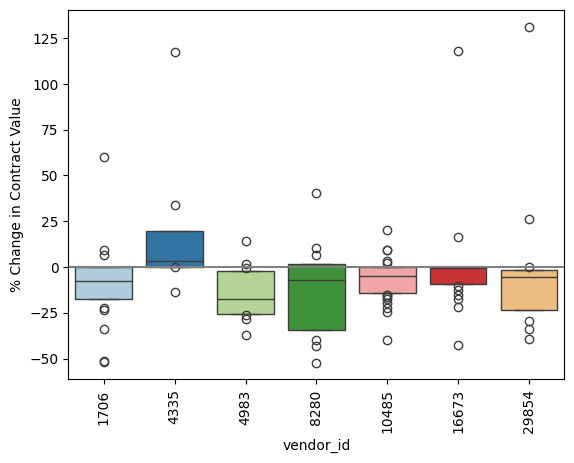

In [ ]:
#graph the price changes for the flagged vendors
a05_significant= u_test_result_closed[u_test_result_closed['pvalue'] <= 0.05]

flagged_vendor_mask = closed['vendor_id'].isin(a05_significant['vendor_id'])
graph_df = closed[flagged_vendor_mask]
palette = sns.color_palette('Paired')
sns.boxplot(data=graph_df, x='vendor_id', y='%_changed', legend=False, palette=palette, hue='vendor_id', whis=0)
plt.axhline(y=0, color='grey', linestyle='-')
plt.xticks(rotation=90)
plt.ylabel('% Change in Contract Value')
plt.show()

The colored areas in the graph depict ranges of % price change where the middle 50% of the price changes occur for each vendor. Those that are below zero have a downward price change bias, and the only one that has a tendancy to increase was vendor 4335.

It seems that now that we have a list of vendors and their tendencies to change their prices we are finished. However, if we want to have very few false positives in our flagging process, and we want to be more certain that these vendors are likely to continue these patterns in the future, we'll have to adjust our flagging threshold for the false discovery rate. The next section will discuss what false discovery is and why we should adjust our results with it in mind.

**Adjusting for False Discovery**

The false discovery rate (FDR) is an issue that occurs when testing large numbers of hypotheses. The Mann-Whitney U test that we used flagged vendors whose price changes had a pattern that was consistenly higher or lower than normal. If there was less than a 5% chance a vendor's price change ranks could be drawn randomly from the set of all price change ranks, I included it in the graph of significant results above. Normally with statistical analysis we accept that theres a small possibility (in this case a 5% chance) that our finding is a false positive due to error.

This low probability of getting a single false positive works well when only testing one hypothesis, but it becomes problematic when testing several things at once. The 5% error rate applies to each test individually, but if I were to test more than one vendor the chance that at least one result is false is much higher than 5%. If I test 20 vendors who are true negatives, there would be a 75% chance that there would be at least one false positive. This is because if one runs a test that has a false positive rate of 5% many times, they would expect that at least 5% of their tests would come back positive on average without any true difference in the population. So when testing each of the 76 vendors (those who had 7 or more sales), it is probably worth applying a standard method that limits this probability of false discovery.

**Benjamini-Hochberg FDR adjustment**

The Benjamini-Hochberg adjustment is the most common way to adjust the result for the false discovery rate. It is often used in situations like gene sequencing. It works by ranking the p-values of the tests from lowest to highest, then checking if there are some p-values that are so small that they are unlikely to have occured by false discovery. [More about Benjamini-Hochberg adjustment](https://en.wikipedia.org/wiki/False_discovery_rate)

In [ ]:
print('number of vendors tested: ' + str(u_test_result_closed.shape[0]))

number of vendors tested: 76


In [ ]:
#define a function that applies the benjamini-hochberg false discovery adjustment
def benjamini_hochberg(pvals, q):

  '''
  Inputs: pvals: an array of of p-values,
          q: desired error tolerance

  Does: applies the benjamini-hochberg FDR adjustment

  Returns: a string that states the number of the lowest p-values which are all significant at the desired error tolerance
  '''

  pvals = np.array(pvals)
  m = len(pvals)
  # Rank p-values
  order = np.argsort(pvals)
  ranked_pvals = pvals[order]

  adjuster = (np.arange(1, m+1) / m) * q #formula for significance of test at each rank i in range (1, m+1)
  passed = ranked_pvals <= adjuster #checks if each pvalue is below the threshold for its rank
  if not np.any(passed):

    # if none of the pvalues are greater than the threshold at their rank - none are significant
    return 'none of the p-values were significant'
  #chose the lowest rank (highest rank number) where the p-value is still lower than the threshold
  max_rank = np.max(np.where(passed)[0])
  cutoff = ranked_pvals[max_rank]
  rejected = pvals <= cutoff
  if (sum(rejected == True) == 1):
    return 'only the test with lowest p-value is significant'
  else:
    return 'the top ' + str(sum(rejected == True)) + ' lowest p-values are all significant'

In [ ]:
#apply the FDR adjustment to the original list of pvalues

#q=.05 indicates that we tolerate a 5% chance of error after multiple testing is accounted for
benjamini_hochberg(u_test_result_closed['pvalue'], q=.05)

'only the test with lowest p-value is significant'

In [ ]:
#result for higher error rate tolerance like 15%

benjamini_hochberg(u_test_result_closed['pvalue'], q=.15)

'the top 3 lowest p-values are all significant'

In [ ]:
u_test_result_closed.head(3) #show the three statistically significant vendors

,vendor_name,vendor_id,pvalue
22,"160 PATTON CONSTRUCTION GROUP, INC. 330 ...",10485,0.00
33,261 MCGILL ASSOCIATES PA 375 MCGILL AS...,1706,0.00
2,10 ENVIRONMENTAL TESTING SOLUTION 1036 ...,4983,0.01


/tmp/ipython-input-2706616616.py:7: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.boxplot(data=graph_df, x='vendor_id', y='%_changed', legend=False, palette=palette, hue='vendor_id', whis=0)


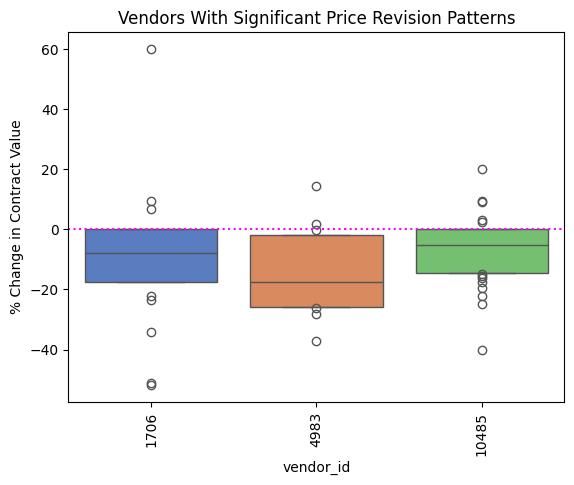

<Figure size 640x480 with 0 Axes>

In [ ]:
#graph the price change tendencies of the significant 3 vendors
final_significant = u_test_result_closed[u_test_result_closed['vendor_id'].isin([10485, 1706, 4983])]

flagged_vendor_mask = closed['vendor_id'].isin(final_significant['vendor_id'])
graph_df = closed[flagged_vendor_mask]
palette = sns.color_palette('muted')
sns.boxplot(data=graph_df, x='vendor_id', y='%_changed', legend=False, palette=palette, hue='vendor_id', whis=0)
plt.axhline(y=0, color='magenta', linestyle=':')
plt.xticks(rotation=90)
plt.ylabel('% Change in Contract Value')
plt.title('Vendors With Significant Price Revision Patterns')
plt.show()

In [ ]:
#list the average % price change for each of the flagged vendors

graph_df.groupby('vendor_id')['%_changed'].describe()

,count,mean,std,min,25%,50%,75%,max
vendor_id,,,,,,,,
1706,19.00,-8.91,23.92,-51.72,-17.69,-7.89,0.00,60.00
4983,10.00,-14.29,16.03,-37.16,-25.84,-17.65,-2.03,14.31
10485,30.00,-6.85,11.59,-40.03,-14.41,-5.17,0.00,20.00
